# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_112  Q6MZW2            16.789
Sample_165  P98095;P98095-2   17.437
Sample_063  Q05996;Q05996-2   15.523
Sample_052  O15041;O15041-2   14.628
Sample_060  O43916            13.579
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_149  P04430           14.769
Sample_052  D6R956;P09936    15.530
Sample_036  F2Z2C8;Q9BVH7    12.882
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.622
            A0A075B6Q5                 12.427
            A0A075B6R2                 12.437
            A0A075B6S5                 12.487
            A0A087WSY4                 13.385
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.724
            Q9UI40;Q9UI40-2            13.540
            Q9UIW2                     13.879
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.379
            Q9UP79                     13.151
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.004,15.050,16.842,19.863,15.587,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.704,19.067,...,15.528,15.576,13.924,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.580,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.391,17.705,17.039,16.145,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.674,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.462,15.345,17.084,18.708,14.249,19.433,12.424,11.098
Sample_207,15.739,16.877,15.469,16.898,14.937,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.542,12.936,13.643,12.217,10.797,12.412,13.956,12.206,12.925,11.843
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.477,19.067,16.127,...,11.230,13.007,13.723,12.561,13.495,12.770,13.005,12.891,12.147,13.104
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.195,13.054,13.949,12.461,11.884,12.525,12.797,13.358,13.021,14.748
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.801,13.473,13.383,12.139,13.111,12.426,13.550,13.829,13.992,12.355
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.155,13.133,13.942,13.080,13.195,11.438,12.102,13.375,13.322,11.276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.542,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 130.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.04it/s]

100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.42it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.46it/s]

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.98it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.42it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.72it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.78it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.15it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.91it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.75it/s]

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.67it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.21it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.58it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.61it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.50it/s]

100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

100%|██████████| 8/8 [00:02<00:00,  3.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.58it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.65it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.79it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.63it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.50it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.38it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.52it/s]

 30%|███       | 3/10 [00:00<00:01,  5.15it/s]

 40%|████      | 4/10 [00:00<00:01,  4.36it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.92it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.74it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.69it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.35it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.70it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.40it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.01it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.82it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.79it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.75it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.61it/s]

100%|██████████| 11/11 [00:02<00:00,  3.90it/s]

100%|██████████| 11/11 [00:02<00:00,  4.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.20it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.13it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.96it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.90it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.92it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.89it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.74it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.65it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.73it/s]

100%|██████████| 12/12 [00:02<00:00,  3.93it/s]

100%|██████████| 12/12 [00:02<00:00,  4.02it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.44it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.72it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.49it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.41it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.41it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.28it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.25it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.49it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.85it/s]

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.24it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.64it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.93it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.72it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.64it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.64it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.66it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.25it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.02it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.83it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.76it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.62it/s]

100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  3.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.70it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.14it/s]

 40%|████      | 6/15 [00:01<00:02,  3.35it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.43it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.29it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.43it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.53it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.36it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.37it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.46it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.70it/s]

100%|██████████| 15/15 [00:04<00:00,  3.82it/s]

100%|██████████| 15/15 [00:04<00:00,  3.51it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.038 0.009          0.650 0.423       0.088   
2             0.004 0.000      0.040 0.010          0.814 0.083       0.726   
3             0.004 0.000      0.040 0.008          0.800 0.077       0.719   
4             0.004 0.001      0.038 0.008          0.806 0.088       0.786   
5             0.004 0.000      0.038 0.001          0.816 0.092       0.785   
6             0.004 0.001      0.039 0.004          0.816 0.094       0.757   
7             0.004 0.001      0.039 0.006          0.810 0.089       0.756   
8             0.004 0.001      0.040 0.008          0.795 0.090       0.754   
9             0.004 0.000      0.039 0.007          0.794 0.079       0.830   
10            0.003 0.001      0.032 0.008          0.792 0.078       0.826   
11            0.004 0.001      0.039 0.005          0.788 0.084       0.825   
12            0.004 0.001      0.037 0.012          0.808 0.080       0.855   
13            0.005 0.003      0.051 0.027          0.822 0.077       0.853   
14            0.005 0.002      0.044 0.013          0.817 0.084       0.832   
15            0.005 0.002      0.047 0.014          0.813 0.084       0.831   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.149 0.126                  0.537 0.039        0.856   
2          0.125   0.762 0.090                  0.802 0.067        0.868   
3          0.122   0.752 0.087                  0.794 0.067        0.869   
4          0.116   0.791 0.086                  0.823 0.071        0.882   
5          0.115   0.796 0.086                  0.827 0.070        0.883   
6          0.117   0.780 0.088                  0.815 0.071        0.886   
7          0.114   0.777 0.085                  0.812 0.067        0.885   
8          0.110   0.769 0.085                  0.805 0.068        0.886   
9          0.105   0.807 0.072                  0.835 0.061        0.910   
10         0.108   0.804 0.072                  0.833 0.061        0.907   
11         0.114   0.801 0.079                  0.830 0.066        0.907   
12         0.090   0.827 0.066                  0.852 0.058        0.918   
13         0.089   0.833 0.063                  0.857 0.055        0.918   
14         0.101   0.821 0.073                  0.847 0.063        0.915   
15         0.101   0.818 0.073                  0.844 0.063        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.825 0.085        210.000 0.000  
2          0.061                  0.853 0.073        210.000 0.000  
3          0.057                  0.856 0.065        210.000 0.000  
4          0.064                  0.876 0.066        210.000 0.000  
5          0.061                  0.876 0.064        210.000 0.000  
6          0.059                  0.876 0.065        210.000 0.000  
7          0.059                  0.875 0.065        210.000 0.000  
8          0.061                  0.876 0.065        210.000 0.000  
9          0.051                  0.897 0.054        210.000 0.000  
10         0.052                  0.893 0.054        210.000 0.000  
11         0.051                  0.895 0.053        210.000 0.000  
12         0.049                  0.909 0.051        210.000 0.000  
13         0.048                  0.906 0.051        210.000 0.000  
14         0.048                  0.901 0.052        210.000 0.000  
15         0.049                  0.900 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 436.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.90it/s]

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.19it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]

100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.83it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.44it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.08it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.85it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.73it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.42it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.85it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.82it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.66it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.82it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.37it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.02it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.66it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.88it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.68it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.62it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.63it/s]

100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.68it/s]

 30%|███       | 3/10 [00:00<00:01,  4.21it/s]

 40%|████      | 4/10 [00:00<00:01,  3.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.36it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.41it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.48it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.73it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.48it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.54it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.44it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.37it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.88it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.07it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.36it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.62it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.31it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.35it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.45it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.42it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.49it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.37it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.40it/s]

100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.82it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.09it/s]

 31%|███       | 4/13 [00:01<00:03,  2.61it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.54it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.45it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.67it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  3.02it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.16it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.32it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.42it/s]

100%|██████████| 13/13 [00:04<00:00,  3.50it/s]

100%|██████████| 13/13 [00:04<00:00,  3.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.13it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.65it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.98it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.60it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.31it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.32it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.81it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.63it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.41it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.58it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.70it/s]

100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.71it/s]

 20%|██        | 3/15 [00:01<00:04,  2.75it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.57it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.53it/s]

 40%|████      | 6/15 [00:02<00:03,  2.48it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.58it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.71it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.93it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.13it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.24it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.35it/s]

100%|██████████| 15/15 [00:05<00:00,  3.38it/s]

100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.054 0.020          0.000 0.000       0.000   
2             0.005 0.003      0.055 0.027          0.761 0.102       0.614   
3             0.004 0.002      0.046 0.020          0.755 0.087       0.660   
4             0.004 0.002      0.046 0.018          0.754 0.091       0.658   
5             0.005 0.002      0.048 0.018          0.747 0.095       0.661   
6             0.005 0.002      0.053 0.018          0.753 0.096       0.688   
7             0.005 0.002      0.049 0.017          0.732 0.100       0.662   
8             0.006 0.003      0.060 0.022          0.726 0.108       0.668   
9             0.006 0.004      0.055 0.025          0.729 0.105       0.676   
10            0.007 0.003      0.066 0.025          0.773 0.091       0.778   
11            0.006 0.003      0.062 0.024          0.771 0.087       0.789   
12            0.006 0.003      0.064 0.028          0.791 0.086       0.798   
13            0.007 0.004      0.067 0.032          0.798 0.089       0.807   
14            0.005 0.002      0.049 0.018          0.809 0.084       0.798   
15            0.006 0.002      0.059 0.021          0.810 0.082       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.129   0.671 0.097                  0.734 0.068        0.780   
3          0.120   0.698 0.087                  0.751 0.062        0.846   
4          0.129   0.696 0.092                  0.750 0.069        0.844   
5          0.127   0.695 0.092                  0.748 0.070        0.843   
6          0.123   0.713 0.092                  0.760 0.071        0.849   
7          0.128   0.688 0.095                  0.741 0.073        0.857   
8          0.128   0.690 0.101                  0.740 0.080        0.865   
9          0.127   0.696 0.098                  0.745 0.078        0.863   
10         0.114   0.771 0.083                  0.804 0.071        0.899   
11         0.117   0.775 0.083                  0.808 0.071        0.901   
12         0.113   0.791 0.081                  0.821 0.070        0.913   
13         0.110   0.799 0.082                  0.828 0.070        0.916   
14         0.118   0.799 0.085                  0.829 0.070        0.917   
15         0.120   0.800 0.085                  0.830 0.071        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.826 0.086        210.000 0.000  
2          0.076                  0.729 0.094        210.000 0.000  
3          0.060                  0.815 0.072        210.000 0.000  
4          0.061                  0.810 0.074        210.000 0.000  
5          0.062                  0.809 0.073        210.000 0.000  
6          0.056                  0.822 0.067        210.000 0.000  
7          0.057                  0.829 0.067        210.000 0.000  
8          0.060                  0.837 0.070        210.000 0.000  
9          0.061                  0.832 0.071        210.000 0.000  
10         0.053                  0.874 0.063        210.000 0.000  
11         0.052                  0.879 0.061        210.000 0.000  
12         0.049                  0.897 0.055        210.000 0.000  
13         0.049                  0.899 0.055        210.000 0.000  
14         0.048                  0.901 0.054        210.000 0.000  
15         0.048                  0.899 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 682.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.67it/s]

100%|██████████| 2/2 [00:00<00:00, 17.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.94it/s]

100%|██████████| 3/3 [00:00<00:00, 22.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.08it/s]

100%|██████████| 4/4 [00:00<00:00, 13.70it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.56it/s]

100%|██████████| 5/5 [00:00<00:00, 19.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.36it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.51it/s]

100%|██████████| 6/6 [00:00<00:00, 10.70it/s]

100%|██████████| 6/6 [00:00<00:00, 11.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.61it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.24it/s]

100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 16.89it/s]

 50%|█████     | 4/8 [00:00<00:00, 10.60it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  9.37it/s]

100%|██████████| 8/8 [00:00<00:00,  9.51it/s]

100%|██████████| 8/8 [00:00<00:00,  9.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.82it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.91it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.59it/s]

100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.10it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.05it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.24it/s]

100%|██████████| 10/10 [00:00<00:00, 13.07it/s]

100%|██████████| 10/10 [00:00<00:00, 13.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.61it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.04it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.54it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.59it/s]

100%|██████████| 11/11 [00:00<00:00, 16.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.60it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.15it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.80it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.44it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.45it/s]

100%|██████████| 12/12 [00:00<00:00, 12.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.99it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.76it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.92it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.22it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.76it/s]

100%|██████████| 13/13 [00:01<00:00, 10.82it/s]

100%|██████████| 13/13 [00:01<00:00, 11.52it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.61it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.74it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.35it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.10it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.48it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.43it/s]

100%|██████████| 14/14 [00:01<00:00, 12.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.69it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.89it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.13it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.66it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.19it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 14.63it/s]

100%|██████████| 15/15 [00:01<00:00, 14.48it/s]

100%|██████████| 15/15 [00:01<00:00, 14.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.019          0.000 0.000       0.000   
2             0.004 0.002      0.046 0.015          0.652 0.083       0.519   
3             0.004 0.002      0.043 0.013          0.650 0.091       0.515   
4             0.004 0.002      0.042 0.012          0.660 0.080       0.512   
5             0.004 0.002      0.046 0.019          0.657 0.091       0.520   
6             0.007 0.003      0.070 0.028          0.656 0.098       0.512   
7             0.005 0.002      0.055 0.027          0.687 0.101       0.588   
8             0.005 0.002      0.048 0.018          0.694 0.106       0.616   
9             0.005 0.002      0.058 0.021          0.688 0.102       0.604   
10            0.006 0.003      0.063 0.025          0.717 0.087       0.673   
11            0.006 0.004      0.061 0.033          0.700 0.079       0.663   
12            0.005 0.003      0.049 0.019          0.713 0.089       0.661   
13            0.007 0.003      0.065 0.024          0.715 0.089       0.672   
14            0.006 0.003      0.059 0.024          0.713 0.086       0.679   
15            0.007 0.003      0.069 0.024          0.715 0.086       0.671   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.739   
2          0.084   0.573 0.069                  0.657 0.050        0.737   
3          0.094   0.569 0.083                  0.655 0.055        0.734   
4          0.089   0.571 0.073                  0.658 0.048        0.736   
5          0.077   0.576 0.067                  0.658 0.052        0.734   
6          0.082   0.570 0.072                  0.655 0.055        0.727   
7          0.114   0.625 0.080                  0.692 0.061        0.789   
8          0.105   0.645 0.080                  0.704 0.064        0.788   
9          0.102   0.636 0.076                  0.697 0.060        0.785   
10         0.106   0.690 0.082                  0.739 0.066        0.807   
11         0.112   0.676 0.079                  0.727 0.062        0.810   
12         0.112   0.680 0.081                  0.731 0.062        0.812   
13         0.113   0.687 0.081                  0.736 0.064        0.807   
14         0.115   0.690 0.083                  0.738 0.064        0.804   
15         0.112   0.686 0.078                  0.735 0.060        0.800   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.685 0.087        210.000 0.000  
2          0.060                  0.699 0.077        210.000 0.000  
3          0.062                  0.698 0.080        210.000 0.000  
4          0.059                  0.697 0.071        210.000 0.000  
5          0.063                  0.691 0.078        210.000 0.000  
6          0.068                  0.683 0.083        210.000 0.000  
7          0.065                  0.753 0.072        210.000 0.000  
8          0.068                  0.753 0.078        210.000 0.000  
9          0.068                  0.749 0.077        210.000 0.000  
10         0.071                  0.771 0.079        210.000 0.000  
11         0.071                  0.773 0.082        210.000 0.000  
12         0.067                  0.774 0.078        210.000 0.000  
13         0.066                  0.768 0.082        210.000 0.000  
14         0.066                  0.763 0.082        210.000 0.000  
15         0.065                  0.760 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,13,15
score_time,13,13,6
test_precision,13,15,10
test_recall,12,13,14
test_f1,13,15,10
test_balanced_accuracy,13,15,10
test_roc_auc,12,14,12
test_average_precision,12,14,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.68it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.07it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.63it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.30it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.16it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.98it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.80it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.27it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.99it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.08it/s]

100%|██████████| 14/14 [00:05<00:00,  2.00it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.84it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.89it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.97it/s]

 50%|█████     | 6/12 [00:00<00:00,  8.27it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  8.47it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  7.95it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  8.15it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.49it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.86it/s]

100%|██████████| 12/12 [00:01<00:00,  8.85it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.52it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.44it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.86it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.47it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.19it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.15it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.36it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.46it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.55it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.68it/s]

100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


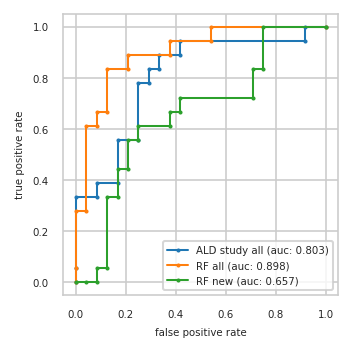

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.333  0.000 0.278  0.083 0.000
3          0.083 0.333  0.042 0.278  0.083 0.056
4          0.083 0.389  0.042 0.611  0.125 0.056
5          0.167 0.389  0.083 0.611  0.125 0.333
6          0.167 0.556  0.083 0.667  0.167 0.333
7          0.250 0.556  0.125 0.667  0.167 0.444
8          0.250 0.778  0.125 0.833  0.208 0.444
9          0.292 0.778  0.208 0.833  0.208 0.556
10         0.292 0.833  0.208 0.889  0.250 0.556
11         0.333 0.833  0.375 0.889  0.250 0.611
12         0.333 0.889  0.375 0.944  0.375 0.611
13         0.417 0.889  0.542 0.944  0.375 0.667
14         0.417 0.944  0.542 1.000  0.417 0.667
15         0.917 0.944  1.000 1.000  0.417 0.722
16         0.917 1.000    NaN   NaN  0.708 0.722
17         1.000 1.000    NaN   NaN  0.708 0.833
18           NaN   NaN    NaN   NaN  0.750 0.833
19           NaN   NaN    NaN   NaN  0.750 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02766,Q96MU8;Q96MU8-2;Q96MU8-3,A0A087WXB8;Q9Y274
2,A0A087WVV2;A0A0A0MRV0;Q9P2E9;Q9P2E9-2;V9GY78,A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2,J3KSJ8;Q9UD71;Q9UD71-2
3,P61981,P02741,P31321
4,P04075,P04075,A0A075B7B8
5,P14174,Q9Y2T3;Q9Y2T3-3,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P61981,A0A0J9YW36;Q9NZ72;Q9NZ72-2
7,P00338;P00338-3,Q96GD0,E9PK25;G3V1A4;P23528
8,P25189;P25189-2,P63104,P31150


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


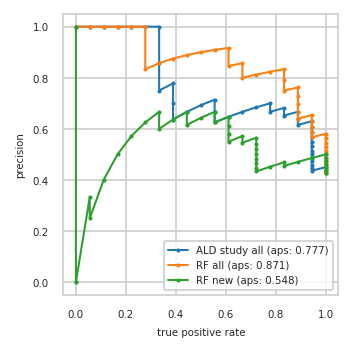

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.567 0.944     0.433 0.722
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.652 0.833     0.696 0.889     0.565 0.722
20         0.682 0.833     0.727 0.889     0.545 0.667
21         0.667 0.778     0.762 0.889     0.571 0.667
22         0.700 0.778     0.750 0.833     0.550 0.611
23         0.684 0.722     0.789 0.833     0.579 0.611
24         0.667 0.667     0.833 0.833     0.611 0.611
25         0.647 0.611     0.824 0.778     0.647 0.611
26         0.625 0.556     0.812 0.722     0.625 0.556
27         0.667 0.556     0.800 0.667     0.667 0.556
28         0.714 0.556     0.857 0.667     0.643 0.500
29         0.692 0.500     0.846 0.611     0.615 0.444
30         0.667 0.444     0.917 0.611     0.667 0.444
31         0.636 0.389     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.667 0.333
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


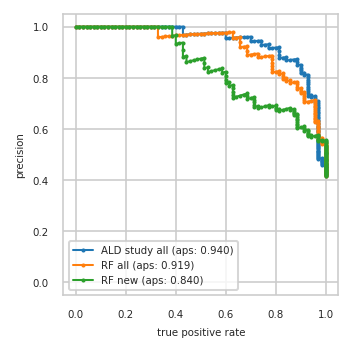

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


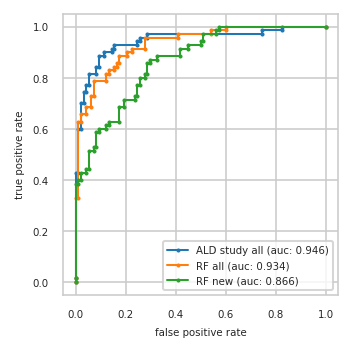

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}